

# CS 209b - Final Project - Spring 2022



-----------------------------------------
-----------------------------------------
# Microbiome Dynamics in Health and Disease
-----------------------------------------
-----------------------------------------


Project guidelines: \\
https://drive.google.com/file/d/1Xbue3vN9FNGqggbYstaFi9YQOe2vQVVn/view?fbclid=IwAR0mDMgloJ_9imgfsWHT4Dqo_TP9C6S1w1kRJ2ryNGKLJoYjdigINRSCunI

-----------
## Data description
--------
The data comes from the paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4689191/. \\
It follows the composition of the gut microbiota of 33 infants that have a predisposition to type 1 diabete (T1D) through the HLA alleles. They are followed from birth until 3 years of age. This study stems from other ones that highlighted the role of the gut microbiota in the development of T1D (mostly in mice).

11 had serum autoantibody positivity (positive for some of the antibodies linked with the disease, called "seroconverters") and 4 of them actually became T1D cases. The 22 other infants, the "controls" were actually selected as to match the gender, HLA genotype and country of the seroconverters.

Two types of sequencing for the microbiome were done: 16S (faster) and Shotgun (higher resolution, more precise and accurate).

In total, there were 777 unique samples sequenced by 16S, with a median of 23 unique samples per individual (minimum 8,
maximum 34). Shotgun metagenomic sequencing was performed on a subset of 124 samples from 19 individuals, including all 11 seroconverters, with a median of 6 samples per individual (minimum 3, maximum 11). 

**The data_16s_patients.csv file has these 777 16S samples.**  
**The shotgun files have the 124 Shotgun samples, shotgun_seq0 corresponds to "Strain level marker recruitment" and shotgun_seq1 to "Species level marker coverage".**

Here is a table describing the non-trivial patient measurements in our data.

| Abbreviations in variables      |  Description |
| -------------- |  ----------- |
| Any food name   |  Concerns the diet of the child.      |
| IAA, ICA, IA-2A, ZNT8A, GADA   | They are antibodies associated with T1D (presence and high level are associated with T1D but do not imply it)     |
| BF| Breastfeeding|
| HLA |As explained above, genes that give a predominance to T1D |
| ABX | Antibiotic|

### Definitions:


1.   **Seroconverters**: a patient is classified as a seroconverter in at least one of the samples examined for that patient there is a positive collection result for at least two of the five antibodies (GADA, IAA, ICA, IA-2A, ZNT8A)
2. **HLA Risk Classes:** indicator for whether a patient carries a predisposing HLA risk allele. It is worth noting that while only 3-7% of the children in the risk classes develop T1D, 70% of T1D cases carry these alleles. 
3.   **Autoantibodies**: analyzed in this study



### Imported Libraries

Google Drive Mounting (Google Collab requirement)

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/drive')
#path = 'drive/MyDrive/Colab_Notebooks_209/CS209_final_project'
path = 'drive/MyDrive/CS209_final_project'

sys.path.insert(1, path)



Mounted at /content/drive


In [ ]:
!pip install scikit-bio

!pip install scipy

     |████████████████████████████████| 8.7 MB 6.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.5.7-cp37-cp37m-linux_x86_64.whl size=2147348 sha256=949819ab2d68d5dd28ab5406be30da7186707eaf232f6c33c94a7020a9b11c25
  Stored in directory: /root/.cache/pip/wheels/1f/62/74/26fe0d34ceff9bf8a381ef629d9156e47138641c1751452422
  Created wheel for hdmedians: filename=hdmedians-0.14.2-cp37-cp37m-linux_x86_64.whl size=454900 sha256=ade61434bae8cceff6243b870948df6668307ab56928313ddecb6abfef315546
  Stored in directory: /root/.cache/pip/wheels/56/5d/28/fb40426fbf6a8c3af88376a227130bbdf81e00177123e1398e
Successfully built scikit-bio hdmedians


In [ ]:
#
# External libraries
#
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
import scipy


import tensorflow as tf 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape, InputLayer, BatchNormalization, Conv1D, Conv2D, ReLU, concatenate, GlobalAveragePooling1D 
from tensorflow.keras import models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical 
from IPython import display

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression,LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

import graphviz




#
# Custom code for preprocessing (utils.py file)
#
import utils


In [ ]:
!python --version

Python 3.7.13


Description of Preprocessing code


We implemented a custom script in the ```utils.py``` to load and preprocess the raw data from the study. In particular, we built code that reshapes the data based on the specified taxonomy level, converts column types and computes some important variables like antibody score and group (seroconverted, control or T1D)

----------
# Exploratory Data Analysis
----------

Loading and Preprocessing of Datasets

In [ ]:
#
# Load Datasets using preprocessing scripts
#
data_16s, data_shotgun, bacteria_16s, bacteria_shotgun, patients = utils.load_data(path)

#
# Preprocess bacteria dataset
#
bacteria_df = utils.pad_reindex(data_16s)

# Generate different taxonomy level measurements
species_bact_data = utils.taxonomy_reshaping(bacteria_df, 'Species', False)
species_bact_data = utils.numerize_df(species_bact_data)

strain_bact_data = utils.taxonomy_reshaping(bacteria_df, 'Strain', False)
strain_bact_data = utils.numerize_df(strain_bact_data)

genus_bact_data = utils.taxonomy_reshaping(bacteria_df, 'Genus', True)
genus_bact_data = utils.numerize_df(genus_bact_data)


#
# Preprocess patients dataset
#
patients = utils.preprocess_patients(patients)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,2

Dataframe is already at the strain level, It remains unchanged
There are 517 T1D diagnosed samples
There are 85 Seropositive samples
There are 175 Non-Converter samples


## A) Patient Data Exploration

### General Demographics


### Food Menu


In [ ]:
foods = ['Barley', 'Buckwheat_Millet', 'Cereal', 'Corn', 'Eggs', 'Fish', 'Infant_Formula', 'Meat', 'Milk_Prod', 'Oat', 'Rice', 'Root_Veg', 'Rye', 'Solid_Food', 'Soy_Prod', 'Veg', 'Wheat']
food_df = data_16s[foods + ['Subject_ID'] + ['T1D_Diagnosed']]

food_df = food_df.astype({col :'int' for col in food_df.columns if col != 'Subject_ID'})

unique_ids = data_16s['Subject_ID'].unique()

food_data = {patient_id: {} for patient_id in unique_ids}
food_total = {}
for patient_id, sub_df in food_df.groupby('Subject_ID'):
    food_data[patient_id]['data'] = sub_df.drop(['T1D_Diagnosed', 'Subject_ID'], axis=1)
    food_data[patient_id]['T1D'] = int(np.mean(sub_df['T1D_Diagnosed'].values))
    food_total[patient_id] = food_data[patient_id]['data'].sum()

# outcome of each patient
patient_outcome = {}
for patient_id in food_data.keys():
    patient_outcome[patient_id] = food_data[patient_id]['T1D']


patient_outcome = pd.DataFrame.from_dict(patient_outcome, orient='index')
patient_outcome.columns = ['T1D_Diagnosed']
patient_outcome

food_total_df = pd.DataFrame.from_dict(food_total, orient='index')
food_total_df = food_total_df.join(patient_outcome)

X = food_total_df.drop('T1D_Diagnosed', axis=1).values
y = food_total_df['T1D_Diagnosed']

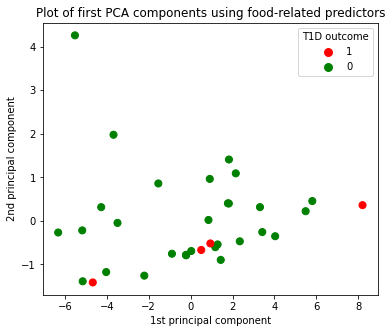

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=2)
res = pca.fit_transform(X)

c2l = {1: 'red', 0: 'green'}
def plot_pca(res, labels, color2label):
    cvec = [color2label[label] for label in labels]
    fig, ax = plt.subplots(figsize=(6, 5))
    scat = ax.scatter(res[:, 0], res[:, 1], c=cvec, s=50)
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')

    legend1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color2label[label], label=label, markersize=10) for label in color2label.keys()]
    ax.legend(handles=legend1, title='T1D outcome')
    plt.title("Plot of first PCA components using food-related predictors")
    plt.show()

plot_pca(res, y.values, c2l)

**Interpretation**

Given that diabetes is a disease related to the metabolism that processes food, one could expect that patient food helps determine whether they develop Type 1 Diabetes. Indeed, not only has food an impact in the Gut Microbiome which might trigger the autoimmune reaction that causes Type 1 Diabetes but also the most common Diabetes of Type 2 is linked to unhealthy eating habits.

In the PCA plot created using food predictors, we can't see any clear clusters that allow to discern between patients with T1D outcome and patients without. 

### Antibody Scores

The study defines patients as "Seroconverted" when they present at least 2 out of five antibodies present. We call this metric "Antibody Score" ranging from 0 (when the patient presents none of the antibodies) to 5 (when the patient presents all 5 and therefore is seroconverted) 
The antibodies measured in this study are:
- GADA
- IAA
- IA-2A
- ICA
- ZNT8A

In [ ]:
# Column names of the Antibodies measured by the study
STUDY_ANTIBODY_COLS = ['GADA_Positive',
'IAA_Positive',
'IA-2A_Positive',
'ICA_Positive',
'ZNT8A_Positive']

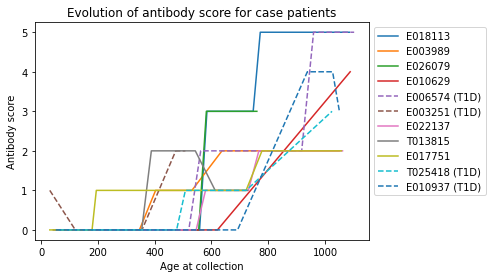

In [ ]:
patients_scores = []
ages_at_collection = [] 
t1d_indicator = [] 
legends = [] 

for patient_id in set(patients["Subject_ID"]): 
    patient_score = [] 
    patient_age = [] 
    is_case = np.mean(patients.loc[patient_id, :]["Case"])
    if is_case > 0: 
        for sample in patients.loc[patient_id]["sample"]: 
            patient_score.append(patients.loc[patient_id, sample]["Antibody_Score"])
            patient_age.append(patients.loc[patient_id, sample]["Age_at_Collection"])
            case = patients.loc[patient_id, sample]["T1D_Diagnosed"]
        patients_scores.append(patient_score)
        t1d_indicator.append(case)
        ages_at_collection.append(patient_age)
        legends.append(patient_id)

for i in range(len(patients_scores)): 
    color = "red" if t1d_indicator[i] else "green"
    if t1d_indicator[i]: 
        color = "red" 
        ls = "--"
        label = legends[i] + " (T1D)"
    else: 
        color = "green"
        ls = "-"
        label = legends[i]
    plt.plot(ages_at_collection[i], patients_scores[i], ls = ls, label = label)
plt.legend(bbox_to_anchor=[1, 1]); 
plt.xlabel("Age at collection"); 
plt.ylabel("Antibody score"); 
plt.title("Evolution of antibody score for case patients");

**Interpretation**

The plot above confirms that in our dataset all of the patients that are not in the control group will have at least one sample with 2 or more positive indicators for the 5 antibodies. This implies that there are no samples collected for the control patients that have 1 positive indicator for any 1 of the samples. This plot also provides some insight that across samples for a patient, the indicator for the antibodies can go from 1 to 0 on later samples. 

## B) Bacterial Sequencing Data Exploration

### Bacteria taxonomy


The study performs bacterial sequencing for multiple strains of bacteria. 
Bacteria are identified using bacteria taxonomy tree which classifies bacteria according to their phylogenetic tree. 
The levels of the bacterial phylogenetic tree are (from broadest to most specific):
- Kingdom
- Phylum
- Classs
- Order
- Family
- Genus
- Species
- Strain
 

In [ ]:
# In this dataset, bacteria names are composed by a maximum of 7 
# concatenated terms (according to bacterial taxonomy)
# 
# Here we generate a dataframe of the bacteria in the dataset 

# Filter column names that are not of bacteria E.g 'Id'
bacteria_names = [col for col in data_16s.columns if col.startswith('k__Bacteria')]

# Create dataframe of bacteria names
taxonomy_analysis = pd.DataFrame(bacteria_names, columns=['name'])

# Split bacteria name into it's 7 components. Note that names with less than seven components 
# are rows corresponding to groups of bacteria (underspecifying)
taxonomy_analysis['name'] = taxonomy_analysis['name'].str.split('|')
column_length = taxonomy_analysis['name'].str.len()

# Keep rows corresponding to individual bacteria types (not groups)
taxonomy_analysis = taxonomy_analysis[column_length==7].reset_index(drop=True)
taxonomy_analysis = taxonomy_analysis.explode('name')

# Make dataframe of bacteria. Note: column names are taken from the taxonomy in the raw data that uses single letters
taxonomy_analysis = pd.DataFrame(np.reshape(taxonomy_analysis['name'].values, (-1, 7)), columns=['k','p','c','o','f','g','s'])


# Clear prefix in Bacteria names E.g 'c__' or 'o__' or 'p__'
taxonomy_analysis = taxonomy_analysis.apply(lambda col: col.str.replace(f'{col.name}__', '') ,axis=0)
taxonomy_analysis.columns = ['Kingdom','Phylum','Class','Order','Family','Genus','Species']


In [ ]:
taxonomy_analysis

,Kingdom,Phylum,Class,Order,Family,Genus,Species
0,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,unclassified
1,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Corynebacteriaceae,Corynebacterium,unclassified
2,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Micrococcaceae,Rothia,mucilaginosa
3,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,adolescentis
4,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,unclassified
...,...,...,...,...,...,...,...
106,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,unclassified
107,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,unclassified,unclassified
108,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,unclassified
109,Bacteria,Tenericutes,Mollicutes,RF39,unclassified,unclassified,unclassified


The counts of distinct categories measured at each taxonomic level are:

In [ ]:
print(f"""
\t- Kingdom Categories : {taxonomy_analysis['Kingdom'].nunique()}
\t- Phylum Categories : {taxonomy_analysis['Phylum'].nunique()}
\t- Class Categories : {taxonomy_analysis['Class'].nunique()}
\t- Order Categories : {taxonomy_analysis['Order'].nunique()}
\t- Family Categories : {taxonomy_analysis['Family'].nunique()}
\t- Genus Categories : {taxonomy_analysis['Genus'].nunique()}
\t- Species Categories : {taxonomy_analysis.shape[0]}
\t- Strains: {len(bacteria_16s.columns)}""")


	- Kingdom Categories : 1
	- Phylum Categories : 8
	- Class Categories : 16
	- Order Categories : 23
	- Family Categories : 42
	- Genus Categories : 63
	- Species Categories : 111
	- Strains: 2428


These include some instances of unclassified Species, fewer instances of unclassified Genus but multiple instances of unclassified Strains where the sequencing couln't determine the exact taxonomy of the observed bacteria. 

---------
# Models
---------

#### Outline of the Implemented models

A) Baseline models

B) RNN

C) LSTM

D) CNN


## A) Baseline Models

We will be fitting 2 baseline models: a multiomial logistic regression model and an XGBoost model. 
There are two important design choices that we applied to both of these models:
- The first is that we decided to fit these models excluding any type of microbiome data, ie. the baseline models are fit on only the patient meta-data found in the "patients" dataset. The reason for this decision is that we can later compare the performance of the baseline models vs the latter models and extract insight about how much additional insight for T1D/Seropositive classification is coming from the micrbiome analysis as opposed to more course-grained data such as the food the patient has been exposed to or simply their antibody levels. 
- The second design choice we made was to aggregate the data across samples at the patient level. Since there is a different number of samples collected per patient and we do not to give more weight to patients with more samples, we normalize the sum of the categorical values by the number of samples. While this approach is not ideal since we lose the time component of the data, because we are only considering patient meta-data (not the results from the microbiome analysis), the normalized sum still represents how much exposure to a certain food type and this approach is still justifiable since the time component of the data is more relevant when considering the evolution of the microbiome. Furthermore, we did attempt to hierarchical models but the models were not benefitting from the added complexity and we were obtaining better results from aggregating at the patient level, which also makes prediction for unseen patients much easier. 

### 1) Multinomial Logistic Regression

One of the downsides of aggregating the data at the patient level is that we reduce the dimension of the dataset significantly and we are left with on 33 observations to fit our model on. Since most of the patient level variables are categorical, we must one hot encode the before fitting a logistic regression model and as such we are left with 72 possible predictors for the patient level data. Since the number of possible predictors is greater than the number of observations, we must select a smaller subset of the predictors to ensure the model is identifiable. In order to select which predictors to include (at most 32), we will rely on plotting the normalized distribution of each predictor per class to see how much variation there is for each predictor across the classes. The goal with this baseline model is to use for later comparison with the models fit using microbiome data so it is important for us to also select predictors that we hypothesize will be correlated with the data shown in the microbiome study (such as food indicators, for instance). 

#### Justifying the selection of predictors for the multinomial logistic regression baseline model

In [ ]:
ALL_PATIENT_PREDICTORS = ['AAB_Post_FistPos', 'AAB_Post_LastNeg', 'AAB_positive',
       'AbxExposureAbsolute', 'Age_at_Collection', 'BF',
       'BF_Exclusive_Duration', 'BF_Exclusive_Positive', 'BF_Long_Term',
       'Barley', 'Buckwheat_Millet',  'Cereal',
       'Collection_Location_Jorvi', 'Corn',
       'Country_Finland', 'DNA_Concentration', 'Delivery_Route_Vaginal',
       'Eggs', 'Exclusive_BF', 'Fish', 'Fruits_Berries', 
       'GADA_Positive', 'Gender_Female', 'IA-2A_Positive',
       'IAA_Positive', 'ICA_Positive', 
       'Infant_Formula', 'Meat', 'Milk_Prod', 'Oat', 'PostAbxExposure',
       'Rice', 'Root_Veg', 'Rye', 'Solid_Food', 'Soy_Prod',  'Total_Reads', 'Veg',
       'Wheat', 'ZNT8A_Positive',
       'AbxAtCollection_Amoxicillin and clavulanic acid',
       'AbxAtCollection_Azithromycin', 'AbxAtCollection_Cefaclor',
       'AbxAtCollection_Cefalexin',
       'AbxAtCollection_Trimetoprime and sulfadiazine',
       'AbxAtCollection_no_abx',
       'AbxPreCollection_Amoxicillin and clavulanic acid',
       'AbxPreCollection_Azithromycin', 'AbxPreCollection_Cefaclor',
       'AbxPreCollection_Cefadroxil', 'AbxPreCollection_Cefalexin',
       'AbxPreCollection_Penicillin V',
       'AbxPreCollection_Trimetoprime and sulfadiazine',
       'AbxPreCollection_no_abx', 'DNA_Yield_Class_1', 'DNA_Yield_Class_2',
       'Flowcell_A2G7T', 'Flowcell_A2RDP', 'Flowcell_A3L91', 'Flowcell_A3MD2',
       'Flowcell_A3RE3', 'Flowcell_A49HE', 'HLA_Risk_Class_3',
       'HLA_Risk_Class_4', 'IllnessAtCollection_ear infection',
       'IllnessAtCollection_no_illness', 'IllnessAtCollection_otitis media',
       'IllnessAtCollection_otitise media',
       'IllnessAtCollection_respitory infection', 'Read_Depth_Class_1',
       'Read_Depth_Class_2', 'Read_Depth_Class_3', 'Group'] 

In [ ]:
def aggregate_patients(patients_df, columns_predictors): 
    patients = patients_df.copy()
    patients_agg = {"patient_id": []}
    for column in patients.columns: 
        if column not in columns_predictors:
            continue 
        else: 
            patients_agg[column] = []
    for patient_id in set(patients["Subject_ID"].values): 
        patients_agg["patient_id"].append(patient_id) 
        for column in patients.columns: 
            if column not in columns_predictors:
                continue 
            average = np.mean(patients.loc[patient_id, :][column])
            patients_agg[column].append(average) 
    return pd.DataFrame(patients_agg)  

In [ ]:
aggregate_patients_df = aggregate_patients(patients, ALL_PATIENT_PREDICTORS)

Some of the columns in the dataset that we must exclude from the model, because they are collinear to the response variable in question, are: Antibody_Score, Subject_ID, Post_T1D_Diag, T1_Diagnosed and Group. We must also ensure that we are removing columns that are co-linear with other predictors, such as the columns for the level of the 5 antibodies that determine seropositivity (since we have the columns indicating positive for that antibody). We also remove the averaged value for Age_at_Collection since the time series aspect of the data is lost in the aggregation of the samples across patients. 

We then plot the remaining columns for the aggregate patient data by group, normalized by the number of patients in each group. This grid of barplots allows us to see whether any of the categorical variables are particularly related to the response (Group). 

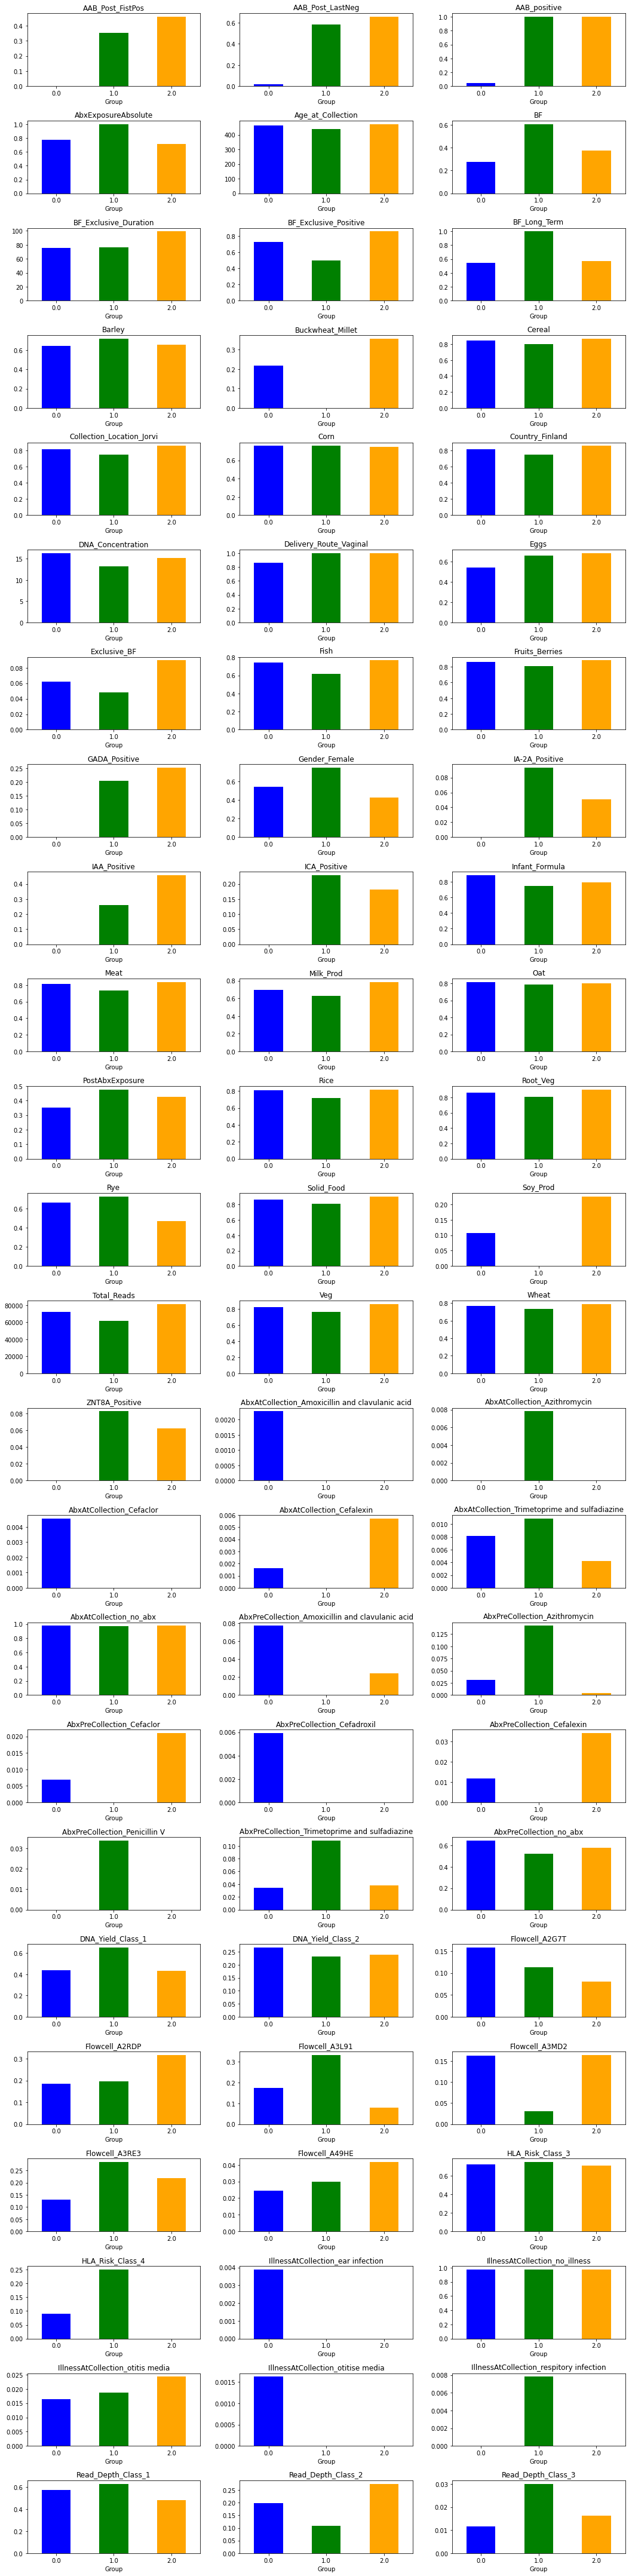

In [ ]:
fig, axs = plt.subplots(24, 3, figsize=(15, 60))
axs = axs.flatten()
color_list = ['blue', 'green', 'orange']
for i, column in enumerate(ALL_PATIENT_PREDICTORS[:-1]): 
   aggregate_patients_df.groupby('Group', as_index=False).mean().plot.bar(x='Group', y=column, rot=0, ax = axs[i], color=color_list, legend=False)
   axs[i].set_title(ALL_PATIENT_PREDICTORS[i]);
fig.tight_layout();

From the gridplot above, we can exclude some predictors that do not seem to add a lot of value in terms of discriminating across the different groups and build a smaller subset with the predictors that do, most importantly AAB_positive and all the indicators for the 5 relevant antibodies. There are some seemingly relevant indicators that we leave out of the logistic regression model, such as the 6 flowcell predictors, due to limit of keeping the number of predictors to less than 33. Now that we have selected which predictors to include in the baseline model, we can redefine the dataframe with aggregate values for each patient with only the relevant columns and fit our baseline model. 

In [ ]:
columns_predictors = ['AAB_positive', 'AbxExposureAbsolute',  
       'Barley', 'Buckwheat_Millet', 'Cereal', 'Corn',
       'Country_Finland', 'DNA_Concentration',
       'Eggs', 'Exclusive_BF', 'Fish', 'Fruits_Berries', 
       'GADA_Positive', 'Gender_Female', 'IA-2A_Positive', 'IAA_Positive', 'ICA_Positive',
       'Infant_Formula', 'Meat', 'Milk_Prod', 'Oat', 'Rice', 'Root_Veg', 'Rye', 'Solid_Food', 'Soy_Prod', 'Veg',
       'Wheat', 'ZNT8A_Positive', 'HLA_Risk_Class_3',
       'HLA_Risk_Class_4', 'Group'] 

aggregate_patients_df = aggregate_patients(patients, columns_predictors)
X = aggregate_patients_df.drop(columns=["Group", "patient_id"])
y = aggregate_patients_df['Group']

#### Fitting the multinomial logistic regression 

In [ ]:
logistic = LogisticRegressionCV(cv=3, max_iter=1000, multi_class='multinomial', refit=True)
logistic.fit(X, y)

LogisticRegressionCV(cv=3, max_iter=1000, multi_class='multinomial')

##### Heatmap of logistic regression predictor coefficients by response class

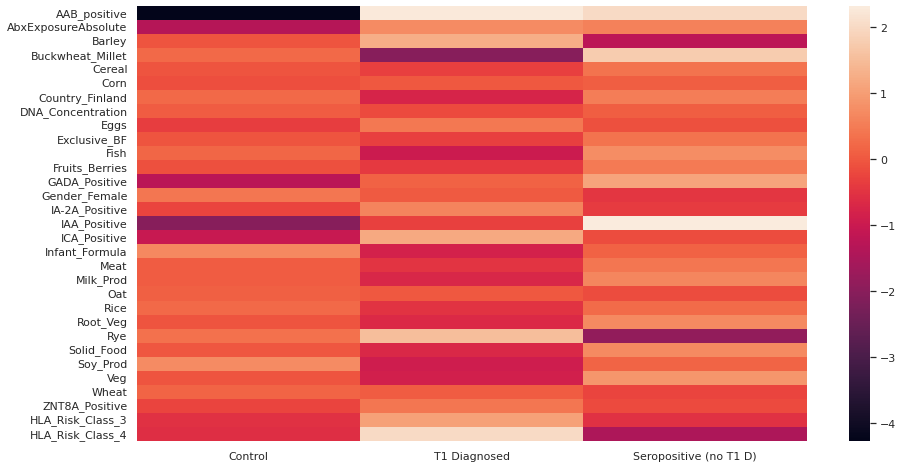

In [ ]:
sns.set_theme()
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(logistic.coef_.transpose(), yticklabels=columns_predictors[:-1], 
       xticklabels=["Control", "T1 Diagnosed", "Seropositive (no T1 D)"])

**Interpretation**

There are a couple of observations that we can make from the heatmap above. The first one is that the majority of the predictors have coefficients cloose to zero for all of the 3 classes, which we can observe from the scale on the right hand side of the plot. However, there are still some valuable insight that we can extract from some of the predictors that have coefficient magnitudes further from 0. For instance, from the plot above we can see that the AAB_positive predictor is by far the predictor whose coefficient has the greatest magnitude and since it is quite negative for the control group but similar for both T1D and Seropositive so while it helps discriminate between the 0 class and the 1/2 classes, it probably provides little discrimination between the 1/2 classes. This is similar to what we observe in the grid of plots above. The predictor that from that heatmap seems to differentiate the most across all three classes is the IAA_positive predictor since it has a strongly negative coefficient for the control class, positve coefficient for the Seropositive class and roughly zero coefficient for the T1D class. Similarly, the HLA Risk Class 4 indicator also seems to have a relatively distinct distribution of coefficient values across the classes. There is only so much information that can be extracted from this plot since it does not really indicate the significance of each predictor as a p-value would but it still allows us to have a good idea of which predictors are more positively/negatively associated with the classes.

Using Cross Validation with ```cross_validate```

In [ ]:
cv_folds = 3
logistic = LogisticRegression(max_iter=1000, multi_class='multinomial')
logistic_cv = cross_validate(logistic, X, y, cv=cv_folds, return_train_score=True, return_estimator=True)
coefs = []

# plotting average accuracy scores during 3 fold cross validation 
for i in range(cv_folds):
  print(f"On fold {i}, the logistic regression has a training score of {logistic_cv['train_score'][i]:.4f} and a validation score of {logistic_cv['test_score'][i]:.4f}")



On fold 0, the logistic regression has a training score of 1.0000 and a validation score of 0.9091
On fold 1, the logistic regression has a training score of 1.0000 and a validation score of 0.7273
On fold 2, the logistic regression has a training score of 0.9545 and a validation score of 0.6364


**Interpretation**

From the results printed out immediately abvoe we can observe overfitting to the training data since the training accuracy for all 3 folds was above 95% (with two folds with 100% accuracy). Nevertheless, the logistic regression model still performs decently on the validation set, between 90.91% and 63.64%. The variation in accurracy in the validation set is worrying since it shows that the model is not that generalizable however, it is expected to an extent given the small size in the training set and the large class imbalance in the data. Due to the small training set size mean that predicting only 1 class differently will change the accuracy by roughly 10% and since there are a lot more 0's than 1's or 2's, the model tends to predict more 0's. When it does so in a validation set where the class imbalance is smaller, the model accuracy is expected to decrease a bit. 

### 2) Tree Ensemble: XGBoost 


One of the advantages of fitting an XGBoost model on the aggregated patient level data is that we no longer fall under the same constraint of requiring less predictors than observations (33). This means we can pass in all of the patient level predictors available and obtain some inference from which predictors are being given more importance in the trees. 

In [ ]:
patients_XGB = aggregate_patients(patients, ALL_PATIENT_PREDICTORS)

# split into train and test (at the patient level)
patient_ids = list(set(patients["Subject_ID"]))
groups = [] 

for id_ in patient_ids:
    groups.append(patients.loc[id_].iloc[0]['Group'])

Train test split

In [ ]:
(train_patients, test_patients, 
 train_groups, test_groups) = train_test_split(patient_ids, 
                                               groups, 
                                               stratify=groups, 
                                               test_size=0.3, 
                                               random_state=109)
 


In [ ]:
aggregate_patients_df.index = aggregate_patients_df["patient_id"]

#### Model 1: XGboost using all available patient level predictors



In [ ]:
aggregate_patients_df = aggregate_patients_df.drop(columns=["patient_id"])
XGB_train = aggregate_patients_df.loc[train_patients, :]
XGB_test =  aggregate_patients_df.loc[test_patients, :]

y_train = XGB_train["Group"]
XGB_train_X = XGB_train.drop(columns=["Group"])

y_test = XGB_test["Group"]
XGB_test_X = XGB_test.drop(columns=["Group"])

model = xgb.XGBClassifier(random_state=209)
model.fit(XGB_train_X, y_train)

XGBClassifier(objective='multi:softprob', random_state=209)

In [ ]:
# make predictions for test data
y_pred = model.predict(XGB_test_X)
predictions = [round(value) for value in y_pred]
np.mean(predictions == y_test)

0.8

The XGBoost model seems to outperform the logistic regression model (at least it achieves better accuracy than 2 out of 3 folds). This indicates that just from the patient meta data there is information that can lead to correct classification into the 3 groups.

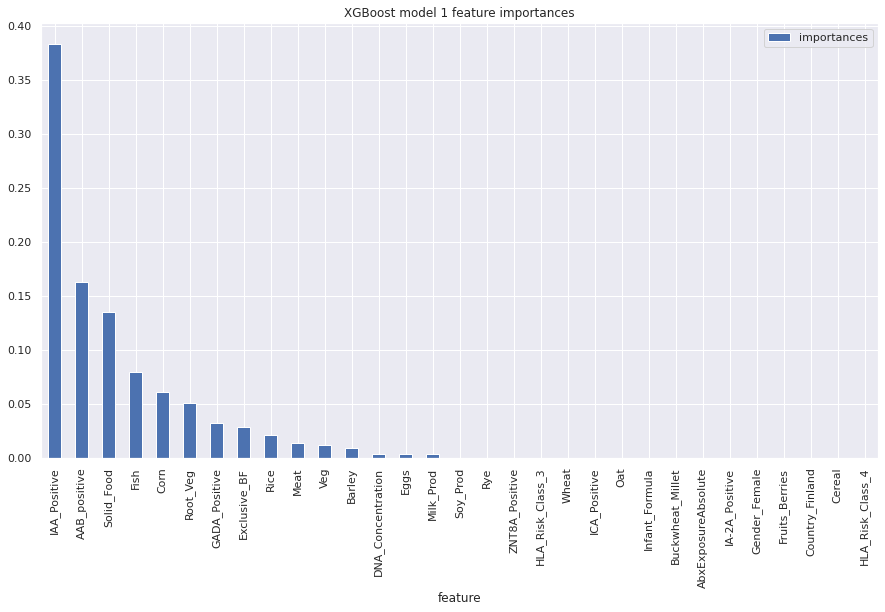

In [ ]:
# plot

model_features_df = pd.DataFrame()
model_features_df["importances"] = model.feature_importances_
model_features_df["feature"] = list(XGB_train_X.columns) 

model_features_df.sort_values(["importances"], ascending=False, inplace=True)

model_features_df.plot.bar(x = 'feature', y = "importances", title = "XGBoost model 1 feature importances");

**Interpretation**

From the importance plot above we can see that IAA_positive is by far the most important predictor, followed by AAB_positive and some diet related predictors. This seems to mostly support the results in the heatmap we plotted for the logistic regression model, with the exception ofthe HLA Risk Class predictor that does not appear to have great importance in this model but showed some discrimination between the groups in the logistic model.

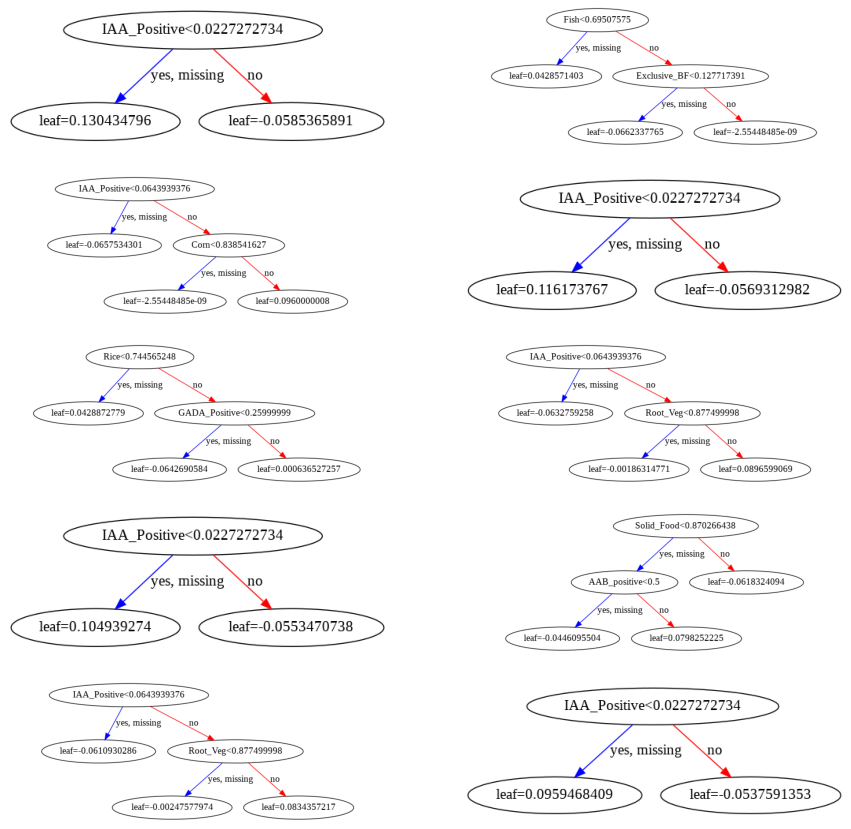

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(15, 15))
axs = axs.flatten()
for i in range(10): 
    xgb.plot_tree(model, num_trees=i, ax=axs[i])

**Interpretation**

Above we see some of the trees produced by the XGB model. Since it seems that most of the splits are a result of the IAA_positive and AAB_positive predictors, we are curious to see how this same model would perform if it did not have access to the antibody data. 

#### Model 2: XGBoost removing Antibody predictors ('AAB_positive', 'GADA_Positive','IA-2A_Positive', 'IAA_Positive', 'ICA_Positive','ZNT8A_Positive')

In [ ]:
XGB_train_noAB = XGB_train_X.drop(columns=['AAB_positive', 'GADA_Positive','IA-2A_Positive', 'IAA_Positive', 'ICA_Positive','ZNT8A_Positive'])
XGB_test_noAB = XGB_test_X.drop(columns=['AAB_positive','GADA_Positive','IA-2A_Positive', 'IAA_Positive', 'ICA_Positive','ZNT8A_Positive'])

In [ ]:
model_noAB = xgb.XGBClassifier(random_state=209)
model_noAB.fit(XGB_train_noAB, y_train)

# make predictions for test data
y_pred_noAB = model_noAB.predict(XGB_test_noAB)
predictions_noAB = [round(value) for value in y_pred_noAB]
np.mean(predictions_noAB == y_test)

0.4

In [ ]:
print("Comparing predictions between XGBoost models")
print("y_test:           ", [int(val) for val in y_test])
print("predictions:      ", predictions)
print("predictions_noAB: ", predictions_noAB)

Comparing predictions between XGBoost models
y_test:            [0, 0, 0, 0, 1, 2, 0, 0, 2, 0]
predictions:       [0, 0, 0, 0, 2, 2, 0, 0, 1, 0]
predictions_noAB:  [0, 1, 2, 2, 0, 0, 0, 0, 0, 0]


Comparing the predictions by XGB model 1 and XGB model 2 provides valuable insight becase we can see what are the mistakes made by the model when predicting. XGB model 1, for instance, does really well even though it has an only 80% accuracy because it correctly separates all of the 0 vs 1/2 patients though it is not that accurate in differentiating between the 1/2 labels. XGB model 2, on the other hand, makes mistakes across all of the classifications and performs pooorly even at just classifying 0's.

In different runs of this model (randomness) we are able to achieve better performance from XGB model 2 of up to 60% test accuracy, in an instance where the model at least predicted most of the 0 classes corretly. 

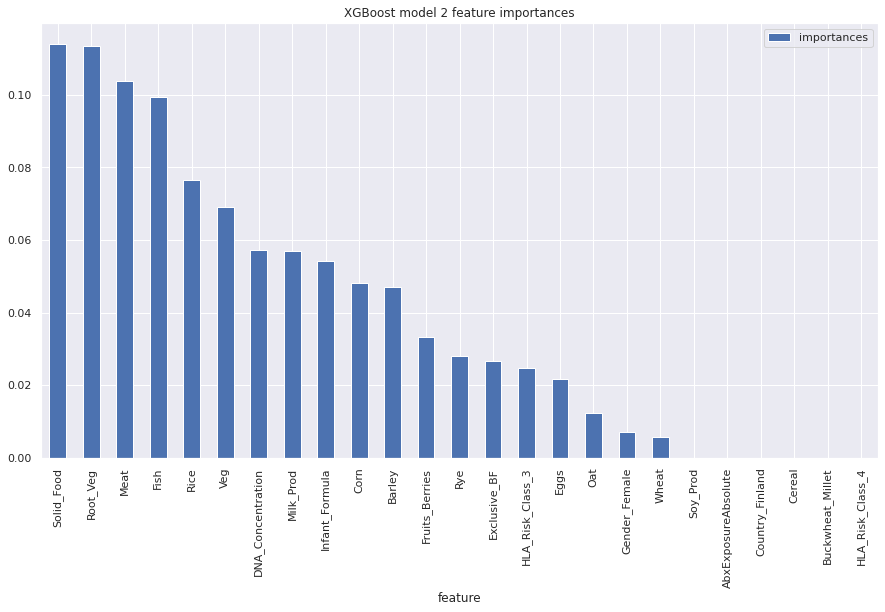

In [ ]:
# plot

model_features_df = pd.DataFrame()
model_features_df["importances"] = model_noAB.feature_importances_
model_features_df["feature"] = list(XGB_train_noAB.columns) 

model_features_df.sort_values(["importances"], ascending=False, inplace=True)

model_features_df.plot.bar(x = 'feature', y = "importances", title = "XGBoost model 2 feature importances");


**Interpretation**

As we remove the antibody related predictors from the XGB boost model, we see significant decrease in its performance, which highlights the fact that those predictors are really important in informing the model. This makes sense since Seroconversion is defined based on the status of the antibody. For the model without that data, the indicators for diet become the most significant predictors which can be seen as further motivation to consider the microbiome data as we expect the diet to impact the microbiome. 

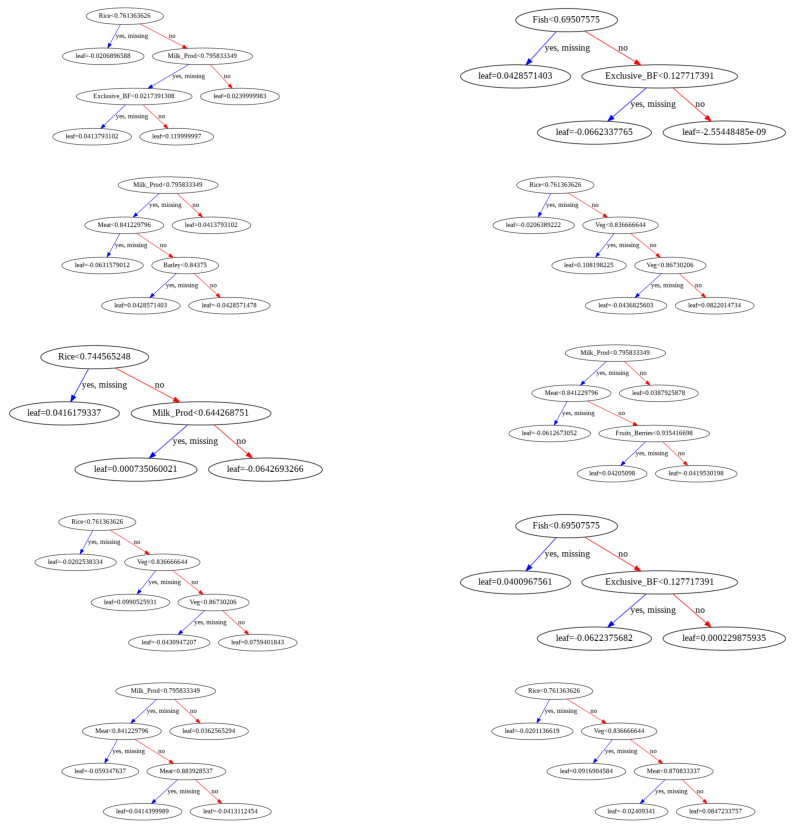

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(15, 15))
axs = axs.flatten()
for i in range(10): 
    xgb.plot_tree(model_noAB, num_trees=i, ax=axs[i])

**Interpretation**

Above we have some example trees generated by XGB model 2 and we observe that all of them have splits based only on diet predictors. One curious fact here is that HLA Risk Class 4 once again does not appeat as an important feature in the feature importance plot and it is not considered in any of the splits seen here. This is interesting since from the grid plot and the heatmap for the logistic regression model it sees that that predictor does provide discrimination across the classes and in the absence of antibody data, we would expect HLA Risk Class 4 to take a larger role as a more important predictor. 

## B) Memory-based Models

We have several timed samples for each patient giving us microbiome data. This timed nature of the data naturally makes us think of using memory-based models (RNNs/LSTMs) to try to predict our pre-defined groups. This is even more interesting given the fact that the paper claims that microbiome **dynamics** are correlated with seroconverters and t1d. Using memory-based models allows us to understand and learn these dynamics by remembering the previous samples every time. In the following two sections, we fit RNNs and LSTMs.

**We also want to note that from one run of the notebook to the other, training metrics might change. The results reported in our final video used the models with the best accuracies over several runs.**

### Recurrent Neural Network Models

#### Species level data

In [ ]:
bacterial_columns = species_bact_data.columns

# Merge Patients and bacteria measurement dataframes to get combined dataset
species_data = pd.merge(patients[['sample', 'T1D_Diagnosed','Subject_ID','Age_at_Collection', 'Case', 'Group'] + STUDY_ANTIBODY_COLS],
                            species_bact_data,
                            left_on='sample',
                            right_index=True,
                            how='right')

# create variable of all of the bacterial measurements as a list
species_data['all_meas'] = species_data[bacterial_columns].apply(lambda row: list(row), axis=1)
species_data = species_data.sort_values(['Subject_ID', 'Age_at_Collection']).groupby("Subject_ID").aggregate(list)

max_len = species_data['all_meas'].str.len().max()

X = species_data['all_meas'].values
X = np.array(pad_sequences(X, max_len, padding='pre', dtype='float32'))


# Run 2 sets of models 
y_2 = np.array([(i[-1]!=0)*1 for i in species_data['Group'].values])
y_3 = np.array([i[-1] for i in species_data['Group'].values])


In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, y_2 ,stratify = y_2,test_size=0.2, random_state=109)
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, y_3 ,stratify = y_3,test_size=0.2, random_state=109)


In [ ]:
y_train3 = tf.keras.utils.to_categorical(y_train3)
y_test3 = tf.keras.utils.to_categorical(y_test3)

In [ ]:
np.unique(y_train2,return_counts=True), np.unique(y_test2,return_counts=True)

((array([0, 1]), array([17,  9])), (array([0, 1]), array([5, 2])))

In [ ]:
print("Naive accuracy when predicting only 0s, train: {}, test: {}".format(17/26, 5/7))

Naive accuracy when predicting only 0s, train: 0.6538461538461539, test: 0.7142857142857143


In [ ]:
#encoding_dim = encoding_dim #If using autoencoder
encoding_dim = 111

In [ ]:
def build_rnn(num_classes, maxlen):
    # Model input
    model_input = tf.keras.Input(shape=(maxlen,encoding_dim), name='sentence_input')

    # Forward RNN layer
    hidden = tf.keras.layers.SimpleRNN(units=maxlen, return_sequences=True)(model_input)
    hidden = tf.keras.layers.SimpleRNN(units=maxlen, return_sequences=True)(hidden)
    hidden = tf.keras.layers.SimpleRNN(units=maxlen, return_sequences=False)(hidden)

    # Define output units and activation based on whether it is a binary 
    # classification problem or a categorical classification problem
    output_units = 1 if num_classes == 2 else num_classes
    output_activation = 'sigmoid' if num_classes == 2 else "softmax"

    # Output Layer
    output = tf.keras.layers.Dense(units=output_units, activation=output_activation)(hidden)

    # Create model
    model = tf.keras.Model(inputs=model_input, outputs=output)

    return model

We will now try to fit our RNN to to predict either two (by combining seroconverters and t1d positivity) or three labels.

In [ ]:
rnn2 = build_rnn(num_classes=2, maxlen=max_len)

rnn2.compile(loss="BinaryCrossentropy",
                  optimizer='Adam',
                  metrics=['accuracy'])


In [ ]:
early_stopping = EarlyStopping(patience=20)
train_hist_rnn2 = rnn2.fit(x_train2, y_train2, epochs=30, validation_data=(x_test2, y_test2),callbacks=[early_stopping])

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 0.6994 - accuracy: 0.6538 - val_loss: 0.6843 - val_accuracy: 0.4286
Epoch 2/30
1/1 [==============================] - 0s 134ms/step - loss: 0.6346 - accuracy: 0.6923 - val_loss: 0.6703 - val_accuracy: 0.4286
Epoch 3/30
1/1 [==============================] - 0s 135ms/step - loss: 0.5793 - accuracy: 0.6923 - val_loss: 0.6670 - val_accuracy: 0.4286
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 0.5223 - accuracy: 0.8077 - val_loss: 0.6613 - val_accuracy: 0.5714
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 0.4780 - accuracy: 0.9231 - val_loss: 0.6455 - val_accuracy: 0.5714
Epoch 6/30
1/1 [==============================] - 0s 133ms/step - loss: 0.4326 - accuracy: 0.9231 - val_loss: 0.6637 - val_accuracy: 0.4286
Epoch 7/30
1/1 [==============================] - 0s 163ms/step - loss: 0.3898 - accuracy: 0.9615 - val_loss: 0.7519 - val_accuracy: 0.5714
Epoch 8/30
1/1 [=======

In [ ]:
#Comparison of predictions and ground truth
np.mean((np.round(rnn2.predict(x_test2).flatten()) == y_test2) * 1)

0.42857142857142855

In [ ]:
rnn3 = build_rnn(num_classes=3,maxlen=max_len)
rnn3.compile(loss="categorical_crossentropy",
                  optimizer='Adam',
                  metrics=['accuracy'])
#rnn3.summary()

In [ ]:
early_stopping = EarlyStopping(patience=20)
train_hist_rnn3 = rnn3.fit(x_train3, y_train3, epochs=50, validation_data=(x_test3, y_test3),callbacks=[early_stopping])

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 1.1845 - accuracy: 0.3846 - val_loss: 1.1423 - val_accuracy: 0.4286
Epoch 2/50
1/1 [==============================] - 0s 175ms/step - loss: 0.9344 - accuracy: 0.5385 - val_loss: 0.9765 - val_accuracy: 0.7143
Epoch 3/50
1/1 [==============================] - 0s 136ms/step - loss: 0.7828 - accuracy: 0.7308 - val_loss: 0.8800 - val_accuracy: 0.7143
Epoch 4/50
1/1 [==============================] - 0s 156ms/step - loss: 0.6955 - accuracy: 0.7308 - val_loss: 0.8329 - val_accuracy: 0.7143
Epoch 5/50
1/1 [==============================] - 0s 144ms/step - loss: 0.6338 - accuracy: 0.7308 - val_loss: 0.8094 - val_accuracy: 0.7143
Epoch 6/50
1/1 [==============================] - 0s 168ms/step - loss: 0.5765 - accuracy: 0.7692 - val_loss: 0.7961 - val_accuracy: 0.7143
Epoch 7/50
1/1 [==============================] - 0s 146ms/step - loss: 0.5198 - accuracy: 0.8077 - val_loss: 0.7873 - val_accuracy: 0.7143
Epoch 8/50
1/1 [=======

With 3 RNN layers, we manage to overfit to the train set (100% accuracy) and get a 85% accuracy on the test set when precidting all 3 classes. Using only 2 classes does not seem to improve our results.

### LSTM Network Models

We do the same but replacing RNNs layers with LSTMs.

#### Species level data


In [ ]:
def build_lstm(num_classes=3, maxlen=max_len):
    # Model input
    model_input = tf.keras.Input(shape=(maxlen,encoding_dim), name='sentence_input')

    hidden = tf.keras.layers.LSTM(units=maxlen, return_sequences=True)(model_input)
    hidden = tf.keras.layers.LSTM(units=maxlen, return_sequences=False)(hidden)

    # Define output units and activation based on whether it is a binary 
    # classification problem or a categorical classification problem
    output_units = 1 if num_classes == 2 else num_classes
    output_activation = 'sigmoid' if num_classes == 2 else "softmax"

    # Output Layer
    output = tf.keras.layers.Dense(units=output_units, activation=output_activation)(hidden)

    # Create model
    model = tf.keras.Model(inputs=model_input, outputs=output)

    return model

In [ ]:
lstm2 = build_lstm(num_classes=2, maxlen=max_len)

lstm2.compile(loss="BinaryCrossentropy",
                  optimizer='Adam',
                  metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10)
train_hist_lstm2 = lstm2.fit(x_train2, y_train2, epochs=30, validation_data=(x_test2, y_test2),callbacks=[early_stopping])

Epoch 1/30
1/1 [==============================] - 10s 10s/step - loss: 0.7004 - accuracy: 0.3077 - val_loss: 0.6963 - val_accuracy: 0.2857
Epoch 2/30
1/1 [==============================] - 0s 48ms/step - loss: 0.6955 - accuracy: 0.3846 - val_loss: 0.6905 - val_accuracy: 0.7143
Epoch 3/30
1/1 [==============================] - 0s 36ms/step - loss: 0.6911 - accuracy: 0.5769 - val_loss: 0.6850 - val_accuracy: 0.7143
Epoch 4/30
1/1 [==============================] - 0s 42ms/step - loss: 0.6871 - accuracy: 0.6538 - val_loss: 0.6798 - val_accuracy: 0.7143
Epoch 5/30
1/1 [==============================] - 0s 39ms/step - loss: 0.6833 - accuracy: 0.6538 - val_loss: 0.6744 - val_accuracy: 0.7143
Epoch 6/30
1/1 [==============================] - 0s 36ms/step - loss: 0.6796 - accuracy: 0.6538 - val_loss: 0.6689 - val_accuracy: 0.7143
Epoch 7/30
1/1 [==============================] - 0s 39ms/step - loss: 0.6758 - accuracy: 0.6538 - val_loss: 0.6630 - val_accuracy: 0.7143
Epoch 8/30
1/1 [===========

In [ ]:
lstm3 = build_lstm(num_classes=3, maxlen=max_len)

lstm3.compile(loss="categorical_crossentropy",
                  optimizer='Adam',
                  metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10)
train_hist_lstm3 = lstm3.fit(x_train3, y_train3, epochs=50, validation_data=(x_test3, y_test3),callbacks=[early_stopping])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 1.1119 - accuracy: 0.2308 - val_loss: 1.1078 - val_accuracy: 0.1429
Epoch 2/50
1/1 [==============================] - 0s 42ms/step - loss: 1.1039 - accuracy: 0.2308 - val_loss: 1.0994 - val_accuracy: 0.2857
Epoch 3/50
1/1 [==============================] - 0s 39ms/step - loss: 1.0966 - accuracy: 0.4231 - val_loss: 1.0915 - val_accuracy: 0.5714
Epoch 4/50
1/1 [==============================] - 0s 42ms/step - loss: 1.0896 - accuracy: 0.5000 - val_loss: 1.0836 - val_accuracy: 0.7143
Epoch 5/50
1/1 [==============================] - 0s 37ms/step - loss: 1.0827 - accuracy: 0.6154 - val_loss: 1.0756 - val_accuracy: 0.7143
Epoch 6/50
1/1 [==============================] - 0s 37ms/step - loss: 1.0757 - accuracy: 0.6538 - val_loss: 1.0674 - val_accuracy: 0.7143
Epoch 7/50
1/1 [==============================] - 0s 40ms/step - loss: 1.0683 - accuracy: 0.6538 - val_loss: 1.0585 - val_accuracy: 0.7143
Epoch 8/50
1/1 [=============

Here we see again that we manage to get a 100% accuracy on the train set and 85.7% on the test set with 2 LSTM layers. We also notice that regrouping the two last classes does not seem to improve anything.

### Conclusion on memory based models

The best that we managed to get using memory-based models is a 100% train accuracy and a 85.7% test accuracy. On the test set, the model manages to predict correctly controls (group 0) and seroconverters (group 2) but predicts incorrectly t1d positives and assigns them group 0. For RNNs, we had to use 3 layers but 2 were enough for LSTMs. This is coherent with the fact that LSTMs have a longer memory than RNNs. Finally, the fact that we got better results using memory-based models compared to the baseline shows that there is indeed a correlation between microbiome dynamics and T1D. 

## D) CNN


# Strategy

## Microbiome representation

At species level, microbiome taxonomy is highly dimensional. We need a way to extract the most important features and patterns, and represent the sample species abundance in vector form. To do so we use an Autoencoder. 

For more precise data, we can use strain-level binary markers (1 for strain presence, 0 else)

### Autoencoders

 - SAE: Shallow Autoencoder: Simple NN, encoding size: 64, 128 etc..
 - DAE: Deep Autoencoder: 2-3 hidden layers that decrease in size, with encoding size 64, 128 etc. As the encoding size decreases, the number of hidden layers increases.
 - VAE: Variational Autoencoder: learns a generalized latent representation under the assumption that the posterior approximation follows Gaussian distribution. [not in lectures]
 - CAE: Convolutional Autoencoder

Taken from: DeepMicro: deep representation learning for disease prediction based on microbiome data.
[paper](https://www.nature.com/articles/s41598-020-63159-5)
[github](https://github.com/minoh0201/DeepMicro)

## Sample level predictions

We want to predict if T1D from a microbiome abundance/strain sample. This model should tell us if there exists a pattern in the microbiome representation. If the model fails to get good accuracy, this means that the evolution of the microbiome is an important factor in determining if a patient will get T1D. 

## Patient level predictions

We want to predict if a patient will develop/has T1D a given time-series of microbiome abundances. Classifier will be based on LSTM models, where the input is a sequence of encoded samples. The output is done at the end of the sequence and will be a binary label.

Analogy: a patient is a sentence, and a sample is a word

Instead of predicting a high level label sur as T1D, we can look at a lower lever score depending on antibody levels/presence, maybe something categorical based on the the average/sum levels/presence of the 4 antibodies. We would then be predicting if a patient is a seroconverter or not depending on his microbiome sequence. 

Our goal for this part is to perform an analysis of the evolution of the strain abundance in the Gut Microbiome through time. 

### Strain-Level Data


In [ ]:
bacterial_columns = strain_bact_data.columns

# Merge Patients and bacteria measurement dataframes to get combined dataset
strain_data = pd.merge(patients[['sample', 'T1D_Diagnosed','Subject_ID','Age_at_Collection', 'Case', 'Group']],
                       strain_bact_data,
                       left_on='sample',
                        right_index=True,
                        how='right')

# create variable of all of the bacterial measurements as a list
strain_data['all_meas'] = strain_data[bacterial_columns].apply(lambda row: list(row), axis=1)
strain_data.sort_values(['Subject_ID', 'Age_at_Collection'], inplace=True)

strain_chao_df = strain_data.copy()

strain_data = strain_data.groupby("Subject_ID").aggregate(list)
max_len = strain_data['all_meas'].str.len().max()

X = strain_data['all_meas'].values
X = np.array(pad_sequences(X, max_len, padding='pre', dtype='float32'))

# Binarize Strain data abundances 
# The strain-level marker profile consists or binary values indicating the presence (1)
# or absence (0) of a certain strain
X = 1*(X>0)


y_3 = np.array([i[-1] for i in strain_data['Group'].values])
y_2 = np.array([(i[-1]!=0)*1 for i in strain_data['Group'].values])



In [ ]:
y_3.shape
print(y_3)

[0. 0. 1. 0. 2. 0. 0. 1. 0. 0. 0. 2. 1. 0. 0. 0. 2. 0. 0. 2. 0. 0. 2. 0.
 2. 0. 0. 0. 2. 0. 0. 1. 0.]


Train-Test Split

In [ ]:
x_train2,x_test2, y_train2, y_test2 = train_test_split(X, y_2 ,stratify = y_2,test_size=0.2, random_state=109)
x_train3,x_test3, y_train3, y_test3 = train_test_split(X, y_3 ,stratify = y_3,test_size=0.2, random_state=109)

In [ ]:
# create categorical target vectors
y_train2_cat, y_test2_cat = to_categorical(y_train2), to_categorical(y_test2)
y_train3_cat, y_test3_cat = to_categorical(y_train3), to_categorical(y_test3)
print(y_train2_cat.shape)
print(y_train3_cat.shape)

# expand dims for cnn
x_train2_exp, x_test2_exp = np.expand_dims(x_train2, axis=-1), np.expand_dims(x_test2, axis=-1)
x_train3_exp, x_test3_exp = np.expand_dims(x_train3, axis=-1), np.expand_dims(x_test3, axis=-1)
print(x_train2_exp.shape)
print(x_train3_exp.shape)

(26, 2)
(26, 3)
(26, 34, 2240, 1)
(26, 34, 2240, 1)


#### **Autoencoder to represent strain-level microbiome data**

Given the large dimension of each strain-level microbiome sample (>2240), we tried to fit an autoencoder. We tried both to learn a low-dimensional representation of individual samples and of individual patients. However, using the low-dimensional representation did not better the models' results. We still include the code for the two autoencoders we defined.

In [ ]:
encoding_dim = 256  
n_features = len(bacterial_columns)

# This is our input image
input_taxonomy = Input(shape=(n_features,))
# "encoded" is the encoded representation of the input
encoded0 = Dense(encoding_dim*2, activation='relu')(input_taxonomy)

encoded = Dense(encoding_dim, activation='relu')(encoded0)
# "decoded" is the lossy reconstruction of the input

decoded0 = Dense(encoding_dim*2, activation='relu')(encoded)

decoded = Dense(n_features, activation='sigmoid')(decoded0)

#Define autoencoder and encoder
autoencoder = Model(input_taxonomy, decoded)
encoder = Model(input_taxonomy, encoded)

#Define decoder
encoded_input = Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))
print(autoencoder.summary())

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2240)]            0         
                                                                 
 dense_30 (Dense)            (None, 512)               1147392   
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 512)               131584    
                                                                 
 dense_33 (Dense)            (None, 2240)              1149120   
                                                                 
Total params: 2,559,424
Trainable params: 2,559,424
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
encoding_dim = 256
n_features = len(bacterial_columns)
input_shape = (max_len, n_features)

# This is our input image
input_taxonomy = Input(shape=input_shape)
flatten_out = Flatten()(input_taxonomy)
# "encoded" is the encoded representation of the input
encoded_0 = Dense(encoding_dim*10, activation='relu')(flatten_out)
encoded_out = Dense(encoding_dim, activation='relu')(encoded_0)
# "decoded" is the lossy reconstruction of the input
decoded_0 = Dense(encoding_dim*10, activation='relu')(encoded_out)
decoded_out = Dense(max_len*n_features, activation='sigmoid')(decoded_0)
reshape_out = Reshape(target_shape=input_shape)(decoded_out)
#Define autoencoder and encoder
autoencoder = Model(input_taxonomy, reshape_out)
encoder = Model(input_taxonomy, encoded_out)
#Define decoder
encoded_input = Input(shape=input_shape)
decoder_layer = autoencoder.layers[-1]

print(autoencoder.summary())

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 34, 2240)]        0         
                                                                 
 flatten (Flatten)           (None, 76160)             0         
                                                                 
 dense_34 (Dense)            (None, 2560)              194972160 
                                                                 
 dense_35 (Dense)            (None, 256)               655616    
                                                                 
 dense_36 (Dense)            (None, 2560)              657920    
                                                                 
 dense_37 (Dense)            (None, 76160)             195045760 
                                                                 
 reshape (Reshape)           (None, 34, 2240)          0  

#### Chao Alpha diversity (See APPENDIX)

#### Individual strain presence over time


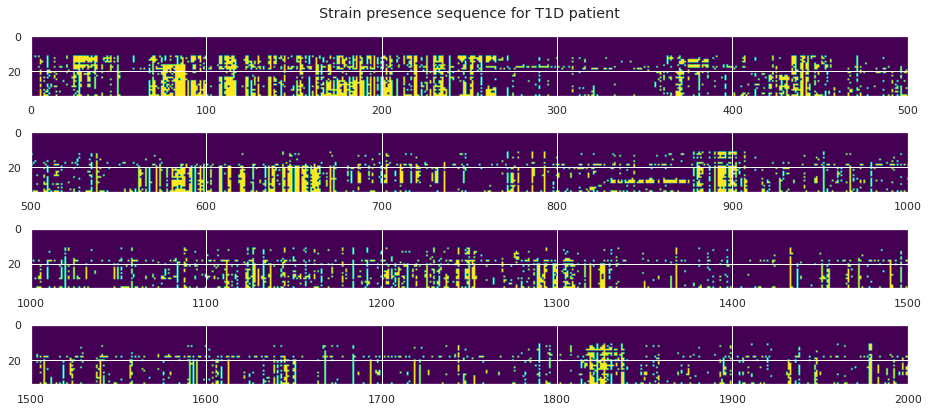

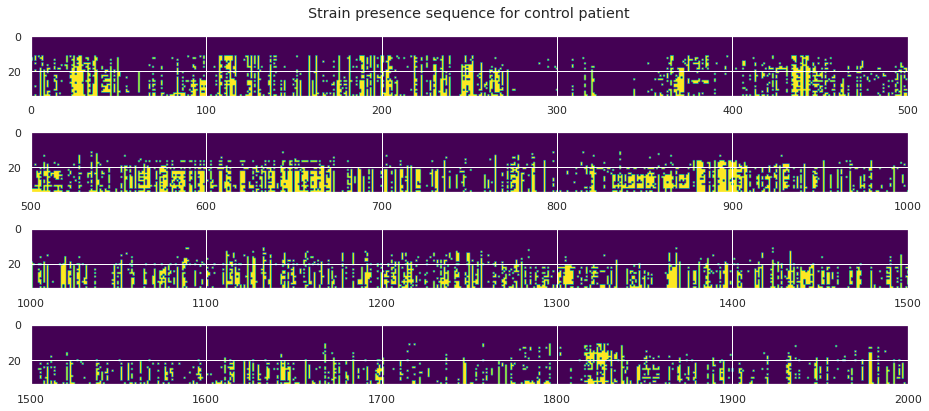

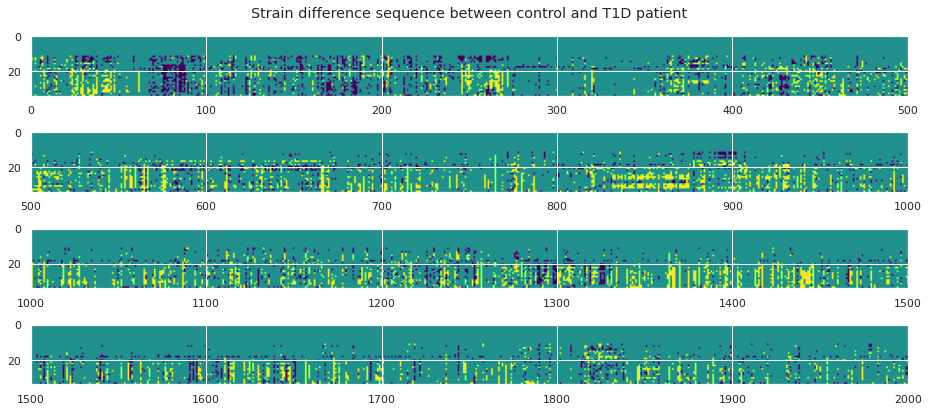

In [ ]:
def plot_seq(seq, title_str):
  n = seq.shape[-1]//500
  fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(20, 6))
  ax = ax.flatten()
  for i in range(n):
    extent = (i*500, (i+1)*500, seq.shape[0], 0)
    ax[i].imshow(seq[:, i*500:(i+1)*500], extent=extent, cmap='viridis')

  fig.suptitle(title_str)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

plot_seq(X[12, :, :], "Strain presence sequence for T1D patient") # T1D 'E010937'
plot_seq(X[6, :, :], "Strain presence sequence for control patient") # control 'E006547'
plot_seq(X[6, :, :]-X[12, :, :], "Strain difference sequence between control and T1D patient")

By looking at the difference in strain presence sequences between a T1D patient and a control patient (with similar sampling frequency) we see that there are clear sregions where the strain presence is different. We can use a CNN model with 2D convolution to extract features from these regions, and 1D convolution to deal with time-series data.

Architecture adapted from:

 Fauvel, Kevin et al. ‘XCM: An Explainable ConvolutionalNeural Network for Multivariate Time Series Classification’. Mathematics 9.23 (2021): 3137. Web.

In [ ]:
n_filters = 16
window_size = 5
cnn_input_shape = (max_len, n_features, 1)
epochs=50

def build_xcm(n_class, cnn_input_shape=cnn_input_shape, n_filters=n_filters, window_size=window_size):
  
  input_layer = Input(shape=cnn_input_shape)
  # 2D convolution layers
  a = Conv2D(filters=n_filters, kernel_size=(window_size, 1), strides=(1, 1), padding='same', input_shape=cnn_input_shape, name='2D')(input_layer)
  a = BatchNormalization()(a)
  a = ReLU(name='2D_Activation')(a)
  a = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), name='2D_Reduced')(a)
  a = ReLU(name='2D_Reduced_Activation')(a)
  x = Reshape((max_len, n_features))(a)

  # 1D convolution layers
  b = Reshape((max_len, n_features))(input_layer)
  b = Conv1D(filters=n_filters, kernel_size=window_size, strides=1, padding='same', name='1D')(b)
  b = BatchNormalization()(b)
  b = ReLU(name='1D_Activation')(b)
  b = Conv1D(filters=1, kernel_size=1, strides=1, name='1D_Reduced')(b)
  y = ReLU(name='1D_Reduced_Activation')(b)

  # Concatenation
  z = concatenate([x, y])

  # 1D convolution layer
  z = Conv1D(filters=n_filters, kernel_size=window_size, strides=1, padding='same', name='1D_Final')(z)
  z = BatchNormalization()(z)
  z = ReLU(name='1D_Final_Activation')(z)

  # 1D global average pooling and classification
  z = GlobalAveragePooling1D()(z)
  if n_class == 2:
    output_layer = Dense(n_class, activation='sigmoid')(z)
  elif n_class > 2: 
    output_layer = Dense(n_class, activation='softmax')(z)

  xcm = Model(input_layer, output_layer, name='CNN_classfier')
  return xcm

xcm2 = build_xcm(2)
xcm3 = build_xcm(3)

In [ ]:
print(xcm2.summary())
xcm2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
history2 = xcm2.fit(x_train2_exp, y_train2_cat, batch_size=16, epochs=epochs, validation_data=[x_test2_exp, y_test2_cat])

Model: "CNN_classfier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 34, 2240, 1  0           []                               
                                )]                                                                
                                                                                                  
 2D (Conv2D)                    (None, 34, 2240, 16  96          ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 reshape_6 (Reshape)            (None, 34, 2240)     0           ['input_7[0][0]']                
                                                                                      

In [ ]:
print(xcm3.summary())
xcm3.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
history3 = xcm3.fit(x_train3_exp, y_train3_cat, batch_size=16, epochs=epochs, validation_data=[x_test3_exp, y_test3_cat])

Model: "CNN_classfier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 34, 2240, 1  0           []                               
                                )]                                                                
                                                                                                  
 2D (Conv2D)                    (None, 34, 2240, 16  96          ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 reshape_8 (Reshape)            (None, 34, 2240)     0           ['input_8[0][0]']                
                                                                                      

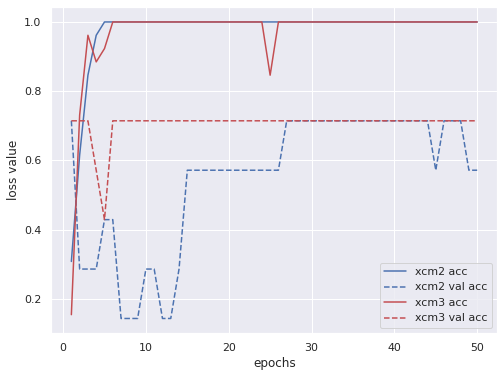

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, epochs+1), history2.history['accuracy'], 'b-', label='xcm2 acc')
plt.plot(np.arange(1, epochs+1), history2.history['val_accuracy'], 'b--', label='xcm2 val acc')
plt.plot(np.arange(1, epochs+1), history3.history['accuracy'], 'r-', label='xcm3 acc')
plt.plot(np.arange(1, epochs+1), history3.history['val_accuracy'], 'r--', label='xcm3 val acc')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()
plt.show()

# APPENDIX:

## Plotting Chao Alpha Diversity

In [ ]:
import skbio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
import utils

data_16s, data_shotgun, bacteria_16s, bacteria_shotgun, patients = utils.load_data()
#
# Preprocess Bacteria
#
bacteria_df = utils.pad_reindex(data_16s)
strain_bacteria_df = utils.taxonomy_reshaping(bacteria_df, 'Strain', False)
strain_bacteria_df = utils.numerize_df(strain_bacteria_df)

#
# Preprocess Patients
#
patients = utils.preprocess_patients(patients)


strain_bacteria_cols = strain_bacteria_df.columns


antibody_cols = ['GADA_Positive',
'IAA_Positive',
'IA-2A_Positive',
'ICA_Positive',
'ZNT8A_Positive']

df_chao = pd.merge(patients[['sample', 'T1D_Diagnosed','Subject_ID','Age_at_Collection', 'Case', 'Group']+antibody_cols],
                   strain_bacteria_df,
                   left_on='sample',
                   right_index=True,
                   how='right')
df_chao.sort_values(['Subject_ID','Age_at_Collection'], inplace=True)


df_chao['chao1_alpha_diversity'] = df_chao.apply(lambda row: skbio.diversity.alpha.chao1(row[strain_bacteria_cols]), axis=1)
df_chao['chao1_alpha_diversity_ci'] = df_chao.apply(lambda row: skbio.diversity.alpha.chao1_ci(row[strain_bacteria_cols]), axis=1)

# defined as being positive for at least two of the five autoantibodies analyzed 
# in this study which are IAA, GADA, IA-2A, ZNT8A, ICA
control_filt = df_chao['Group'] == 0
T1D_diagnosed_filt = df_chao['Group'] == 1
seropositive_filt = df_chao['Group'] == 2


# non-converter (not seroconverted, not T1D), 
# seroconverted (seroconverters, not diagnosed with T1D), 
# and T1D cases (seroconverted subjects also diagnosed with T1D)
control_unique_subjects = df_chao.loc[control_filt,'Subject_ID'].unique()
T1D_unique_subjects = df_chao.loc[T1D_diagnosed_filt,'Subject_ID'].unique()
Seropositive_notT1D_unique_subjects = df_chao.loc[seropositive_filt,'Subject_ID'].unique()




xnew = np.arange(150, 500, 10)

interpolation_degree = 3

serop_poly_y = []
serop_interp_y = []

for subject in Seropositive_notT1D_unique_subjects:
    subject_filt = df_chao['Subject_ID'] == subject
    x = df_chao[subject_filt]
    y = df_chao.loc[subject_filt,'chao1_alpha_diversity']
    
    f_interp = interp1d(x['Age_at_Collection'], y,
                        kind='linear',
                        bounds_error=True)
    serop_interp_y.append(f_interp(xnew))
    
 
serop_interp_y = np.array(serop_interp_y)
serop_interp_y_mean = np.mean(serop_interp_y, axis=0)
serop_interp_y_std = np.std(serop_interp_y, axis=0)

serop_poly_y = np.array(serop_poly_y)
serop_poly_y_mean = np.mean(serop_poly_y, axis=0)
serop_poly_y_std = np.std(serop_poly_y, axis=0)


plt.plot(xnew, 
         serop_interp_y_mean,
         color='green', label='Sero-converter')

plt.fill_between(xnew, 
                 serop_interp_y_mean-serop_interp_y_std, 
                 serop_interp_y_mean+serop_interp_y_std, 
                 alpha=0.2, 
                 color='green')





nonconv_poly_y = []
nonconv_interp_y = []
for subject in control_unique_subjects:
    subject_filt = df_chao['Subject_ID'] == subject
    x = df_chao[subject_filt]
    y = df_chao.loc[subject_filt,'chao1_alpha_diversity']
    f_interp = interp1d(x['Age_at_Collection'], y,
                        kind='linear',
                        bounds_error=True)
        
    nonconv_interp_y.append(f_interp(xnew))
    

nonconv_interp_y = np.array(nonconv_interp_y)
nonconv_interp_y_mean = np.mean(nonconv_interp_y, axis=0)
nonconv_interp_y_std = np.std(nonconv_interp_y, axis=0)

nonconv_interp_y = np.array(nonconv_interp_y)
nonconv_interp_y_mean = np.mean(nonconv_interp_y, axis=0)
nonconv_interp_y_std = np.std(nonconv_interp_y, axis=0)


plt.plot(xnew, 
         nonconv_interp_y_mean,
         color='red', label='Non-Converter')

plt.fill_between(xnew, 
                 nonconv_interp_y_mean - nonconv_interp_y_std, 
                 nonconv_interp_y_mean + nonconv_interp_y_std , 
                 alpha=0.2, 
                 color='red')



T1D_poly_y = []
T1D_interp_y = []
for subject in T1D_unique_subjects:
    subject_filt = df_chao['Subject_ID'] == subject
    x = df_chao[subject_filt]
    y = df_chao.loc[subject_filt,'chao1_alpha_diversity']
    f_interp = interp1d(x['Age_at_Collection'], y,
                        kind='linear',
                        bounds_error=True)
        
    T1D_interp_y.append(f_interp(xnew))



T1D_interp_y = np.array(T1D_interp_y)
T1D_interp_y_mean = np.mean(T1D_interp_y, axis=0)
T1D_interp_y_std = np.std(T1D_interp_y, axis=0)
plt.plot(xnew, 
         T1D_interp_y_mean,
         color='blue', label='T1D')
plt.fill_between(xnew, 
                 T1D_interp_y_mean-T1D_interp_y_std, 
                 T1D_interp_y_mean+T1D_interp_y_std, 
                 alpha=0.2, 
                 color='blue')


plt.title('Plot of Chao1 alpha-diversity across time')
plt.xlabel('Age at Sample Collection (days)')
plt.ylabel('Alpha-diversity')
plt.legend()

plt.show();

